## Install the package dependencies before running this notebook

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

s = """
    number of trajectories in each city 
    # austin --  train: 43041 test: 6325
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    """
print(s)



    number of trajectories in each city 
    # austin --  train: 43041 test: 6325
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    


## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

# Returns entire dataset for a city. Training input and label output, or just test input.
def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    f_in = os.path.join(ROOT_PATH, split, f"{city}_inputs")
    inputs = pickle.load(open(f_in, "rb"))
    inputs = np.asarray(inputs) # All input trajectories
    outputs = None # Labels when training, empty if testing
    
    if split=="train":
        f_out = os.path.join(ROOT_PATH, split, f"{city}_outputs")
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)

    return inputs, outputs

"""Dataset class for Argoverse"""
class ArgoverseDataset(Dataset):
    def __init__(self, city:str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform
        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)
    def __len__(self):
        return len(self.inputs)
    def __getitem__(self, idx):
        data = (self.inputs[idx], self.outputs[idx]) # Each data is a tuple of (input trajectory, output trajectory)
        if self.transform:
            data = self.transform(data)
        return data

## Checking loss graphs 

loading mlp1


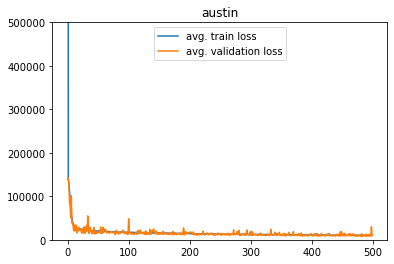

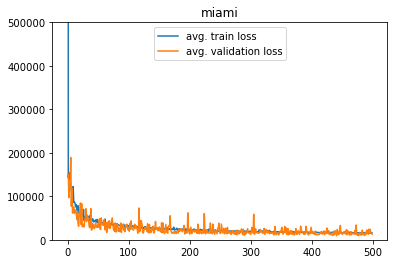

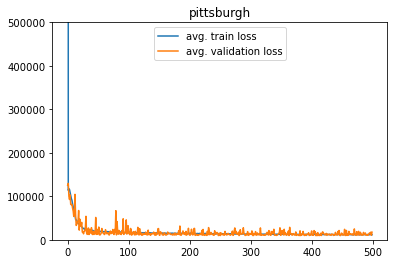

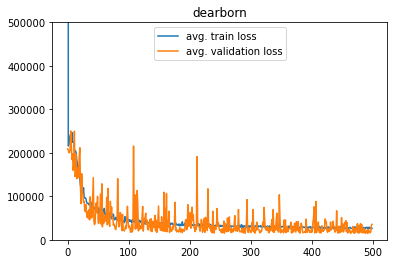

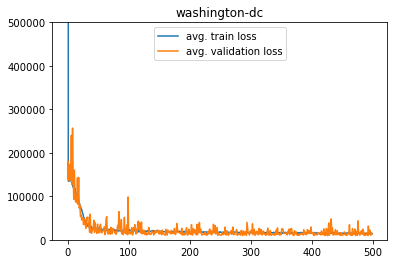

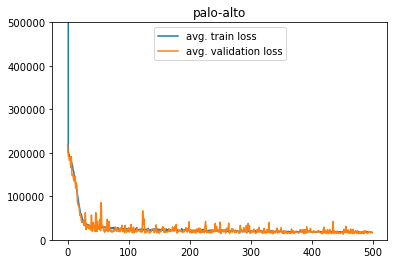

<class 'dict'>


In [5]:
# !pwd
# str = "why is pickle broken?"
# with open("pickle", "wb") as f:
#     print("dumping")
#     pickle.dump(str,f)
#     f.close()
#     print("dumped?")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker    
with open("mlp1", "rb") as g:
    print("loading mlp1")
    data_dict = pickle.load(g)
    for city_number,city in enumerate(cities):
        all_losses1 = data_dict[f"train_losses_{city}"]
        all_losses2 = data_dict[f"validation_losses_{city}"]  
#         data_dict[""]
        plt.figure()
        ax = plt.gca()
        ax.set_ylim([0,500000])
        plt.title(city)
        plt.plot(all_losses1,label="avg. train loss")
        plt.plot(all_losses2,label="avg. validation loss")
        leg = plt.legend(loc='upper center')
        plt.show()
#     print(f"newstr = {newstr}")
#     g.close()
print(type(data_dict))

## Inference on test set

In [17]:
# Inference for every city's test inputs
format_str = "ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,v35,v36,v37,v38,v39,v40,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50,v51,v52,v53,v54,v55,v56,v57,v58,v59,v60,v61,v62,v63,v64,v65,v66,v67,v68,v69,v70,v71,v72,v73,v74,v75,v76,v77,v78,v79,v80,v81,v82,v83,v84,v85,v86,v87,v88,v89,v90,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119"
with open('predictions.txt', 'w') as f:
    print(format_str,end='',file=f)
    for city_number,city in enumerate(cities):
        print(f"Starting testing for {city}.")

        # Prepare inputs
        test_inputs, _ = get_city_trajectories(city=city, split='test', normalized=False)
        print(f"test_inputs.shape = {test_inputs.shape}")
        num_scenes = test_inputs.shape[0]

        # Setup the model
        model, model_state_dict = data_dict[f"model_{city}"]
        model.cuda()
        model.eval()

        # Pass all inputs through model
        for i,input_scene in enumerate(test_inputs):
            input_scene = torch.from_numpy(input_scene).unsqueeze(0).float().cuda() # Convert to tensor+float, move to GPU
            output_scene = model(input_scene)
            output_scene = torch.squeeze(output_scene)
#             print(f"output_scene.shape = {output_scene.shape}")
            # Process output into submission format
            output_str = f"\n{i}_{city}" # Ex. 0_austin
            for j,coord_pair in enumerate(output_scene):
                x,y = coord_pair
                output_str += f",{x},{y}"
            # Print to file
            print(output_str,end='',file=f)
#             break
#         break
        
    
    
    # Process model outputs
    


Starting testing for austin.
test_inputs.shape = (6325, 50, 2)
Starting testing for miami.
test_inputs.shape = (7971, 50, 2)
Starting testing for pittsburgh.
test_inputs.shape = (6361, 50, 2)
Starting testing for dearborn.
test_inputs.shape = (3671, 50, 2)
Starting testing for washington-dc.
test_inputs.shape = (3829, 50, 2)
Starting testing for palo-alto.
test_inputs.shape = (1686, 50, 2)


## Loop over all cities

Starting training for austin.
train_samples_per_epoch = 35856
validation_samples_per_epoch = 7168
(train) epoch 1,      avg. train loss     : 6145368.721868376
(validation) epoch 1, avg. validation loss: 139408.23214285713
(train) epoch 2,      avg. train loss     : 138831.8470147953
(validation) epoch 2, avg. validation loss: 141833.00170898438
(train) epoch 3,      avg. train loss     : 130253.72727716422
(validation) epoch 3, avg. validation loss: 128183.01596505301
(train) epoch 4,      avg. train loss     : 112283.87797980115
(validation) epoch 4, avg. validation loss: 84832.93182809012
(train) epoch 5,      avg. train loss     : 95272.58890509956
(validation) epoch 5, avg. validation loss: 78908.22845458984
(train) epoch 6,      avg. train loss     : 76467.08510866383
(validation) epoch 6, avg. validation loss: 50130.49766322545
(train) epoch 7,      avg. train loss     : 60830.57037045753
(validation) epoch 7, avg. validation loss: 101462.88345772879
(train) epoch 8,      avg. t

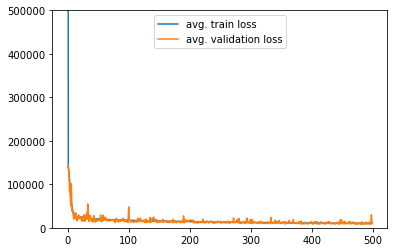



Starting training for miami.
train_samples_per_epoch = 45856
validation_samples_per_epoch = 9168
(train) epoch 1,      avg. train loss     : 24297233.951935135
(validation) epoch 1, avg. validation loss: 144060.06795375218
(train) epoch 2,      avg. train loss     : 144376.73983775298
(validation) epoch 2, avg. validation loss: 150749.2107398015
(train) epoch 3,      avg. train loss     : 139302.25454684228
(validation) epoch 3, avg. validation loss: 97026.13249890925
(train) epoch 4,      avg. train loss     : 144115.9799181132
(validation) epoch 4, avg. validation loss: 116768.84320462478
(train) epoch 5,      avg. train loss     : 154345.51632351818
(validation) epoch 5, avg. validation loss: 125149.69982547993
(train) epoch 6,      avg. train loss     : 117556.93653911157
(validation) epoch 6, avg. validation loss: 189342.26044393543
(train) epoch 7,      avg. train loss     : 115375.68671970407
(validation) epoch 7, avg. validation loss: 77345.2452586442
(train) epoch 8,      av

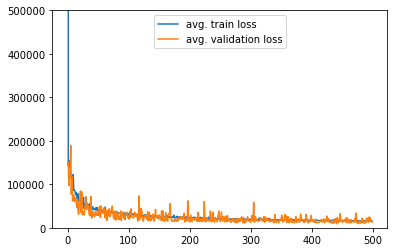



Starting training for pittsburgh.
train_samples_per_epoch = 36272
validation_samples_per_epoch = 7248
(train) epoch 1,      avg. train loss     : 19110719.834055882
(validation) epoch 1, avg. validation loss: 125747.37142142661
(train) epoch 2,      avg. train loss     : 113697.32541629908
(validation) epoch 2, avg. validation loss: 129723.88523558223
(train) epoch 3,      avg. train loss     : 117536.68896807455
(validation) epoch 3, avg. validation loss: 100048.3333419564
(train) epoch 4,      avg. train loss     : 115633.52964235499
(validation) epoch 4, avg. validation loss: 92792.61877414459
(train) epoch 5,      avg. train loss     : 109041.81453927961
(validation) epoch 5, avg. validation loss: 103279.39788562362
(train) epoch 6,      avg. train loss     : 101931.5100628584
(validation) epoch 6, avg. validation loss: 81318.02550703642
(train) epoch 7,      avg. train loss     : 95045.8263140301
(validation) epoch 7, avg. validation loss: 80820.72329435707
(train) epoch 8,     

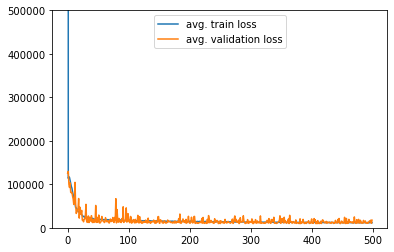



Starting training for dearborn.
train_samples_per_epoch = 20384
validation_samples_per_epoch = 4064
(train) epoch 1,      avg. train loss     : 147272696.26188433
(validation) epoch 1, avg. validation loss: 209314.9778543307
(train) epoch 2,      avg. train loss     : 215792.0224563383
(validation) epoch 2, avg. validation loss: 206882.73068405513
(train) epoch 3,      avg. train loss     : 219057.60848582222
(validation) epoch 3, avg. validation loss: 200487.04007750985
(train) epoch 4,      avg. train loss     : 234515.23581608123
(validation) epoch 4, avg. validation loss: 200321.38790292814
(train) epoch 5,      avg. train loss     : 239621.18710140305
(validation) epoch 5, avg. validation loss: 206911.61386564962
(train) epoch 6,      avg. train loss     : 242449.31243867739
(validation) epoch 6, avg. validation loss: 250340.35279281496
(train) epoch 7,      avg. train loss     : 231139.90215978218
(validation) epoch 7, avg. validation loss: 219385.25581323818
(train) epoch 8,  

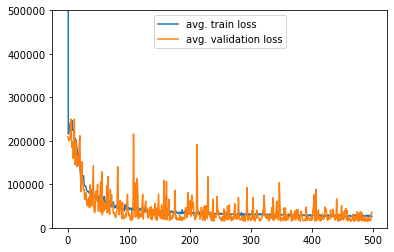



Starting training for washington-dc.
train_samples_per_epoch = 21440
validation_samples_per_epoch = 4288
(train) epoch 1,      avg. train loss     : 45440988.297181085
(validation) epoch 1, avg. validation loss: 141011.0022737873
(train) epoch 2,      avg. train loss     : 135029.2175023321
(validation) epoch 2, avg. validation loss: 180456.0601096082
(train) epoch 3,      avg. train loss     : 134390.96048857277
(validation) epoch 3, avg. validation loss: 135895.6128439832
(train) epoch 4,      avg. train loss     : 138403.7601358442
(validation) epoch 4, avg. validation loss: 148270.08654967352
(train) epoch 5,      avg. train loss     : 136273.8708313899
(validation) epoch 5, avg. validation loss: 173413.25029151118
(train) epoch 6,      avg. train loss     : 140256.60574860073
(validation) epoch 6, avg. validation loss: 137404.71807952426
(train) epoch 7,      avg. train loss     : 134933.8606926306
(validation) epoch 7, avg. validation loss: 240327.72093633396
(train) epoch 8,  

In [ ]:
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

data_dict = {}

# Set hyperparameters
batch_size = 16
lr = 0.0001
num_epochs = 500
data_dict["batch_size"] = batch_size
data_dict["lr"] = lr
data_dict["num_epochs"] = num_epochs

# Train one model per city
models = [ None for city in cities ]
for city_number,city in enumerate(cities):
    print(f"Starting training for {city}.")
    # Prepare Dataset and Dataloader
    full_dataset  = ArgoverseDataset(city = city, split = 'train')
    train_set, validation_set = torch.utils.data.random_split(full_dataset, [int(len(full_dataset)*5/6), len(full_dataset)-int(len(full_dataset)*5/6)])
    train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True,drop_last=True,pin_memory=True)
    validation_loader = DataLoader(validation_set, batch_size=batch_size,drop_last=True)
    train_samples_per_epoch = len(train_loader) * batch_size # Number of batches times batch size
    validation_samples_per_epoch = len(validation_loader) * batch_size
    print(f"train_samples_per_epoch = {train_samples_per_epoch}")
    print(f"validation_samples_per_epoch = {validation_samples_per_epoch}")
    
    # Create model/optim/loss
    model = nn.Sequential(nn.Flatten(1,2),
                    nn.Linear(100, 256),
                    nn.ReLU(),
                    nn.Linear(256,256),
                    nn.ReLU(),
                    nn.Linear(256,120),
                    nn.Unflatten(1,(60,2)))
    model.cuda()
    opt = torch.optim.Adam(model.parameters(),lr=lr)
    loss_func = nn.MSELoss(reduction='sum')
    
    # Train model
    all_losses1 = []
    all_losses2 = []
    start_time = time.time()
    for epoch in range(num_epochs):
        # Train set
        model.train()
        train_loss = 0
        train_loss_alt = 0
        for i_batch, sample_batch in enumerate(train_loader):
            # Get input and output labels
            inp, out = sample_batch 
            inp = inp.float()
            out = out.float()      
            inp, out = inp.cuda(), out.cuda()
            # Forward pass
            out_hats = model(inp)
            l = loss_func(out_hats, out)     
            # Gradient descent
            opt.zero_grad()
            l.backward()
            opt.step()        
            train_loss += l.item()
        all_losses1.append(train_loss / train_samples_per_epoch)  # Loss per training sample

        # Validation set
        model.eval()
        validation_loss = 0
        validation_loss_alt = 0
        for i_batch, sample_batch in enumerate(validation_loader):
            inp, out = sample_batch
            inp = inp.float()
            out = out.float()
            inp, out = inp.cuda(), out.cuda()
            # Forward pass
            l = loss_func(model(inp), out)
            validation_loss += l.item()
        all_losses2.append(validation_loss / validation_samples_per_epoch) # Loss per validation sample

        # Print training progress
        print(f'(train) epoch {epoch + 1},      avg. train loss     : {train_loss / train_samples_per_epoch}')
        print(f'(validation) epoch {epoch + 1}, avg. validation loss: {validation_loss / validation_samples_per_epoch}')
        
    end_time = time.time()
    print(f"Entire training of {city}'s model took {end_time-start_time} seconds.")    
    models[city_number] = model
    data_dict[f"model_{city}"] = (model, model.state_dict())
    data_dict[f"train_losses_{city}"]  = all_losses1
    data_dict[f"validation_losses_{city}"]  = all_losses2

    # Graph training progress, should be per trajectory loss
    plt.figure()
    ax = plt.gca()
    ax.set_ylim([0,500000])
    plt.plot(all_losses1,label="avg. train loss")
    plt.plot(all_losses2,label="avg. validation loss")
    leg = plt.legend(loc='upper center')
    plt.show()    
    print()
    print()
data_dict["models"] = models    
# data_dir = os.path.join("/home/mhsiu/argo_kaggle/checkpoints/mlp1")
# print(data_dir)
with open("mlp1", "wb") as f:
    print("dumping")
    pickle.dump(data_dict,f)
    f.close()
    print("dumped?")
    
# with open("mlp1", "rb") as f:
#     print("loading")
#     loaded = pickle.load(f)
#     newstr = loaded["num_epochs"]
#     print(f"loaded = {newstr}")
#     f.close()
# #     print("dumped?")    

## Inference on test sets

## Create a DataLoader class for training

In [4]:
batch_sz = 4  # batch size 
fullcity_loader = DataLoader(city_dataset,batch_size=batch_sz)
print(f"{split.upper()} dataloader using batches of {batch_sz} is ready for city {city.upper()}.")

TRAIN dataloader using batches of 4 is ready for city PALO-ALTO.


## Sample a batch of data and visualize 

Loaded batch #0
    Shape is (batch, trajectory_length, coord_dim)
    inp shape = torch.Size([4, 50, 2])
    out shape = torch.Size([4, 60, 2])
    batch_sz = 4
    agent_sz = 50

Each column is one (input,output) pair


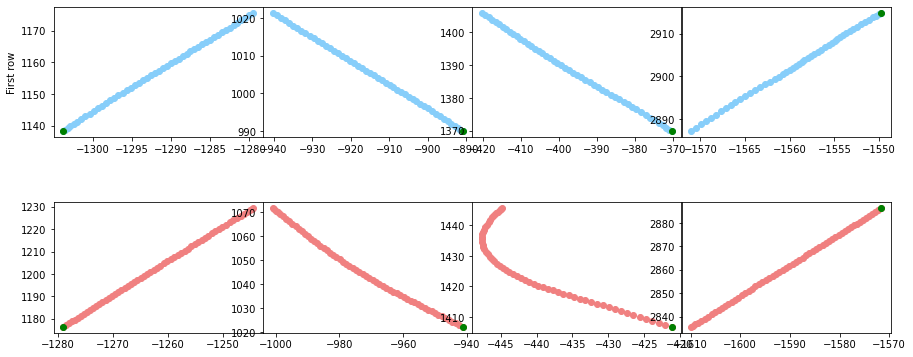

In [5]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    print(f"    Shape is (batch, trajectory_length, coord_dim)")
    print(f"    inp shape = {inp.shape}")
    print(f"    out shape = {out.shape}")
    batch_sz = inp.size(0)
    agent_sz = inp.size(1) # Input trajectory length?
    print(f"    batch_sz = {batch_sz}")
    print(f"    agent_sz = {agent_sz}")
    
    fig, axs = plt.subplots(2,batch_sz, figsize=(15, 6), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
#     axs = axs.ravel()   
    print("\nEach column is one (input,output) pair")
    axs[0][0].set_ylabel("First row")
    for i in range(batch_sz):
        # first two feature dimensions are (x,y) positions
        axs[0][i].scatter(inp[i,:,0], inp[i,:,1], c='lightskyblue')
        axs[1][i].scatter(out[i,:,0], out[i,:,1], c='lightcoral')
        # Show position at first time step
        axs[0][i].scatter(inp[i,0,0], inp[i,0,1], c='g')
        axs[1][i].scatter(out[i,0,0], out[i,0,1], c='g')        

        
for ith_batch, sample_batch in enumerate(fullcity_loader):
    print(f"Loaded batch #{ith_batch}")
    inp, out = sample_batch #
    """
    TODO:
      implement your Deep learning model
      implement training routine
    """
    show_sample_batch(sample_batch)
    break

## Training Loop

In [8]:

# loss = nn.MSELoss()
# input = torch.arange(12,dtype=torch.float32).reshape((3,4))
# print(input)
# target = input + 2
# print(target)
# output = loss(input,target)
# print(output)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")
!nvidia-smi -L

device = cuda
GPU 0: GeForce GTX 1080 Ti (UUID: GPU-d6df5c12-bb16-7de9-a4ce-b011f33dc39f)


In [78]:

# '''
# Define model
mlp = nn.Sequential(nn.Flatten(1,2),
                    nn.Linear(100, 256),
                    nn.ReLU(),
                    nn.Linear(256,256),
                    nn.ReLU(),
                    nn.Linear(256,120),
                    nn.Unflatten(1,(60,2)))

mlp.cuda()

# Hyperparameters
lr = 0.0001
num_epochs = 100
opt = torch.optim.Adam(mlp.parameters(),lr=lr)
# opt = torch.optim.SGD(mlp.parameters(),lr=lr)
loss_func = nn.MSELoss(reduction='sum')

# Train/val split
city = 'palo-alto' 
split = 'train'
full_dataset  = ArgoverseDataset(city = city, split = split)
train_set, validation_set = torch.utils.data.random_split(full_dataset, [int(len(full_dataset)*5/6), len(full_dataset)-int(len(full_dataset)*5/6)])

# Dataloaders
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size,shuffle=True,drop_last=True,pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size,drop_last=True)
train_samples_per_epoch = len(train_loader) * batch_size # Number of batches times batch size
validation_samples_per_epoch = len(validation_loader) * batch_size
print(f"train_samples_per_epoch = {train_samples_per_epoch}")
print(f"validation_samples_per_epoch = {validation_samples_per_epoch}")

all_losses1 = []
all_losses2 = []
# '''

# lr = 0.0001
# num_epochs = 100
# opt = torch.optim.Adam(mlp.parameters(),lr=lr)


import time
# from math import sqrt
from tqdm import tqdm
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start = time.time()
    # Epoch for train set
    mlp.train()
    train_loss = 0
    train_loss_alt = 0
    for i_batch, sample_batch in enumerate(tqdm(train_loader)):
        inp, out = sample_batch # Get input and output labels
        inp = inp.float()
        out = out.float()      
        inp, out = inp.cuda(), out.cuda()
#         print(f"inp.shape = {inp.shape}")
#         break
#         print(f"out shape = {out.shape}")
        
        # Forward pass
        out_hats = mlp(inp)
#         print(out_hats.shape)
        l_alt = ((mlp(inp) - out) ** 2).sum()
        l = loss_func(out_hats, out)     
        # Gradient descent
        opt.zero_grad()
        l.backward()
        opt.step()        
        train_loss += l.item()
        train_loss_alt += l_alt.item()
    all_losses1.append(train_loss / train_samples_per_epoch)  # Loss per training sample
        
    # Epoch for validation set
    mlp.eval()
    validation_loss = 0
    validation_loss_alt = 0
    for i_batch, sample_batch in enumerate(tqdm(validation_loader)):
        inp, out = sample_batch
        inp = inp.float()
        out = out.float()
        inp, out = inp.cuda(), out.cuda()
        # Forward pass
        l_alt = ((mlp(inp) - out) ** 2).sum()
        l = loss_func(mlp(inp), out)
        validation_loss += l.item()
        validation_loss_alt += l_alt.item()
    all_losses2.append(validation_loss / validation_samples_per_epoch) # Loss per validation sample
    
    # Print training progress
    print(f'(train) epoch {epoch + 1},      avg. train loss     : {train_loss / train_samples_per_epoch}')
    print(f'(validation) epoch {epoch + 1}, avg. validation loss: {validation_loss / validation_samples_per_epoch}')
    print(f"Epoch took {time.time()-epoch_start} seconds.\n")
    
end_time = time.time()
print(f"Entire training of {num_epochs} epochs took {end_time-start_time} seconds.")

train_samples_per_epoch = 9984
validation_samples_per_epoch = 1984


100%|██████████| 124/124 [00:00<00:00, 980.93it/s]


(train) epoch 1,      avg. train loss     : 22563257.841821916
(validation) epoch 1, avg. validation loss: 212142.7338079637
Epoch took 1.7576756477355957 seconds.



100%|██████████| 124/124 [00:00<00:00, 1035.03it/s]


(train) epoch 2,      avg. train loss     : 196151.87615184294
(validation) epoch 2, avg. validation loss: 183135.47328629033
Epoch took 1.6670024394989014 seconds.



100%|██████████| 124/124 [00:00<00:00, 876.53it/s]


(train) epoch 3,      avg. train loss     : 187210.04482797475
(validation) epoch 3, avg. validation loss: 192283.02627268145
Epoch took 1.8325402736663818 seconds.



100%|██████████| 124/124 [00:00<00:00, 989.75it/s] 


(train) epoch 4,      avg. train loss     : 182537.53923778044
(validation) epoch 4, avg. validation loss: 198991.99351058467
Epoch took 1.7287161350250244 seconds.



100%|██████████| 124/124 [00:00<00:00, 1057.28it/s]


(train) epoch 5,      avg. train loss     : 179915.12454301884
(validation) epoch 5, avg. validation loss: 173549.68781502015
Epoch took 1.7290852069854736 seconds.



100%|██████████| 124/124 [00:00<00:00, 1127.74it/s]


(train) epoch 6,      avg. train loss     : 174950.2217172476
(validation) epoch 6, avg. validation loss: 186635.6154233871
Epoch took 1.7060413360595703 seconds.



100%|██████████| 124/124 [00:00<00:00, 875.17it/s]


(train) epoch 7,      avg. train loss     : 167966.8411708734
(validation) epoch 7, avg. validation loss: 154877.20362903227
Epoch took 1.833294153213501 seconds.



100%|██████████| 124/124 [00:00<00:00, 813.58it/s]


(train) epoch 8,      avg. train loss     : 162525.69373497597
(validation) epoch 8, avg. validation loss: 163048.0972152218
Epoch took 1.889747142791748 seconds.



100%|██████████| 124/124 [00:00<00:00, 864.59it/s]


(train) epoch 9,      avg. train loss     : 156274.94474283853
(validation) epoch 9, avg. validation loss: 129423.97649949597
Epoch took 2.0388011932373047 seconds.



100%|██████████| 124/124 [00:00<00:00, 993.64it/s] 


(train) epoch 10,      avg. train loss     : 142689.82205278447
(validation) epoch 10, avg. validation loss: 132275.7326108871
Epoch took 1.7497437000274658 seconds.



100%|██████████| 124/124 [00:00<00:00, 1024.95it/s]


(train) epoch 11,      avg. train loss     : 136969.45216721756
(validation) epoch 11, avg. validation loss: 130614.33833165323
Epoch took 1.5538837909698486 seconds.



100%|██████████| 124/124 [00:00<00:00, 999.46it/s]


(train) epoch 12,      avg. train loss     : 128932.64715419672
(validation) epoch 12, avg. validation loss: 112341.02633568548
Epoch took 1.5583486557006836 seconds.



100%|██████████| 124/124 [00:00<00:00, 1046.11it/s]


(train) epoch 13,      avg. train loss     : 116356.08823492588
(validation) epoch 13, avg. validation loss: 151636.91588961694
Epoch took 1.5388095378875732 seconds.



100%|██████████| 124/124 [00:00<00:00, 1052.34it/s]


(train) epoch 14,      avg. train loss     : 110048.18751878005
(validation) epoch 14, avg. validation loss: 96614.53118699597
Epoch took 1.5928616523742676 seconds.



100%|██████████| 124/124 [00:00<00:00, 1012.06it/s]


(train) epoch 15,      avg. train loss     : 99099.56931089744
(validation) epoch 15, avg. validation loss: 98326.2404548891
Epoch took 1.5872907638549805 seconds.



100%|██████████| 124/124 [00:00<00:00, 1041.85it/s]


(train) epoch 16,      avg. train loss     : 88831.85002253606
(validation) epoch 16, avg. validation loss: 107567.1521232359
Epoch took 1.700190782546997 seconds.



100%|██████████| 124/124 [00:00<00:00, 914.18it/s]


(train) epoch 17,      avg. train loss     : 81999.61013559195
(validation) epoch 17, avg. validation loss: 72603.93170362903
Epoch took 1.8077833652496338 seconds.



100%|██████████| 124/124 [00:00<00:00, 1018.49it/s]


(train) epoch 18,      avg. train loss     : 72617.63117550581
(validation) epoch 18, avg. validation loss: 70084.35594128024
Epoch took 1.6449651718139648 seconds.



100%|██████████| 124/124 [00:00<00:00, 1008.73it/s]


(train) epoch 19,      avg. train loss     : 65498.813986753805
(validation) epoch 19, avg. validation loss: 64568.36863659274
Epoch took 1.7029297351837158 seconds.



100%|██████████| 124/124 [00:00<00:00, 1088.19it/s]


(train) epoch 20,      avg. train loss     : 65697.36324055989
(validation) epoch 20, avg. validation loss: 47318.36580141129
Epoch took 1.613689661026001 seconds.



100%|██████████| 124/124 [00:00<00:00, 1018.50it/s]


(train) epoch 21,      avg. train loss     : 56574.53052696815
(validation) epoch 21, avg. validation loss: 45868.067839591735
Epoch took 1.7152247428894043 seconds.



100%|██████████| 124/124 [00:00<00:00, 1052.82it/s]


(train) epoch 22,      avg. train loss     : 52993.03586363181
(validation) epoch 22, avg. validation loss: 44531.70544039818
Epoch took 1.8219599723815918 seconds.



100%|██████████| 124/124 [00:00<00:00, 985.83it/s] 


(train) epoch 23,      avg. train loss     : 48682.124896709734
(validation) epoch 23, avg. validation loss: 47331.88610446068
Epoch took 1.7197935581207275 seconds.



100%|██████████| 124/124 [00:00<00:00, 793.02it/s]


(train) epoch 24,      avg. train loss     : 48187.95402018229
(validation) epoch 24, avg. validation loss: 43449.065949470765
Epoch took 2.0407681465148926 seconds.



100%|██████████| 124/124 [00:00<00:00, 1081.21it/s]


(train) epoch 25,      avg. train loss     : 44580.01122264373
(validation) epoch 25, avg. validation loss: 37713.424899193546
Epoch took 1.7976012229919434 seconds.



100%|██████████| 124/124 [00:00<00:00, 891.77it/s]


(train) epoch 26,      avg. train loss     : 42280.06524345202
(validation) epoch 26, avg. validation loss: 31250.48172095514
Epoch took 1.7388942241668701 seconds.



100%|██████████| 124/124 [00:00<00:00, 984.90it/s]


(train) epoch 27,      avg. train loss     : 43502.00667004708
(validation) epoch 27, avg. validation loss: 33968.22330204133
Epoch took 1.6900289058685303 seconds.



100%|██████████| 124/124 [00:00<00:00, 1008.73it/s]


(train) epoch 28,      avg. train loss     : 34886.45353190104
(validation) epoch 28, avg. validation loss: 34170.745109311996
Epoch took 1.8577427864074707 seconds.



100%|██████████| 124/124 [00:00<00:00, 820.42it/s]


(train) epoch 29,      avg. train loss     : 34159.39513377654
(validation) epoch 29, avg. validation loss: 32182.959740423386
Epoch took 1.8482098579406738 seconds.



100%|██████████| 124/124 [00:00<00:00, 1084.22it/s]


(train) epoch 30,      avg. train loss     : 37542.506727952226
(validation) epoch 30, avg. validation loss: 31989.065689579133
Epoch took 1.8877918720245361 seconds.



100%|██████████| 124/124 [00:00<00:00, 877.53it/s]


(train) epoch 31,      avg. train loss     : 39851.98303222656
(validation) epoch 31, avg. validation loss: 34440.909762474796
Epoch took 1.8514049053192139 seconds.



100%|██████████| 124/124 [00:00<00:00, 995.91it/s]


(train) epoch 32,      avg. train loss     : 34826.70025165264
(validation) epoch 32, avg. validation loss: 21468.677718623992
Epoch took 1.6619594097137451 seconds.



100%|██████████| 124/124 [00:00<00:00, 902.66it/s]


(train) epoch 33,      avg. train loss     : 34036.09255120693
(validation) epoch 33, avg. validation loss: 31610.979051159273
Epoch took 1.7842278480529785 seconds.



100%|██████████| 124/124 [00:00<00:00, 1093.69it/s]


(train) epoch 34,      avg. train loss     : 34889.45376821665
(validation) epoch 34, avg. validation loss: 21732.562216481856
Epoch took 1.741459608078003 seconds.



100%|██████████| 124/124 [00:00<00:00, 864.58it/s]


(train) epoch 35,      avg. train loss     : 32481.574037209535
(validation) epoch 35, avg. validation loss: 31726.91146358367
Epoch took 1.893223524093628 seconds.



100%|██████████| 124/124 [00:00<00:00, 981.26it/s]


(train) epoch 36,      avg. train loss     : 29446.941830366086
(validation) epoch 36, avg. validation loss: 36842.40832913307
Epoch took 1.7564818859100342 seconds.



100%|██████████| 124/124 [00:00<00:00, 1013.51it/s]


(train) epoch 37,      avg. train loss     : 35396.50450564653
(validation) epoch 37, avg. validation loss: 45332.03154926915
Epoch took 1.4723258018493652 seconds.



100%|██████████| 124/124 [00:00<00:00, 1038.98it/s]


(train) epoch 38,      avg. train loss     : 29197.697994134363
(validation) epoch 38, avg. validation loss: 31915.14322391633
Epoch took 1.4918653964996338 seconds.



100%|██████████| 124/124 [00:00<00:00, 977.50it/s]


(train) epoch 39,      avg. train loss     : 33250.95568065154
(validation) epoch 39, avg. validation loss: 25168.11591166835
Epoch took 1.6017365455627441 seconds.



100%|██████████| 124/124 [00:00<00:00, 1052.33it/s]


(train) epoch 40,      avg. train loss     : 30377.598305726664
(validation) epoch 40, avg. validation loss: 23118.766184160788
Epoch took 1.6469435691833496 seconds.



100%|██████████| 124/124 [00:00<00:00, 1001.73it/s]


(train) epoch 41,      avg. train loss     : 29315.426720252402
(validation) epoch 41, avg. validation loss: 29590.750244140625
Epoch took 1.7481744289398193 seconds.



100%|██████████| 124/124 [00:00<00:00, 902.43it/s]


(train) epoch 42,      avg. train loss     : 31682.413666553988
(validation) epoch 42, avg. validation loss: 27913.030328566027
Epoch took 1.7966585159301758 seconds.



100%|██████████| 124/124 [00:00<00:00, 1039.29it/s]


(train) epoch 43,      avg. train loss     : 32485.00578425481
(validation) epoch 43, avg. validation loss: 26103.577431955644
Epoch took 1.7613956928253174 seconds.



100%|██████████| 124/124 [00:00<00:00, 892.51it/s]


(train) epoch 44,      avg. train loss     : 26562.999389648438
(validation) epoch 44, avg. validation loss: 27248.622330204133
Epoch took 1.9489483833312988 seconds.



100%|██████████| 124/124 [00:00<00:00, 1046.58it/s]


(train) epoch 45,      avg. train loss     : 30415.758415026543
(validation) epoch 45, avg. validation loss: 24895.170181766633
Epoch took 1.6610171794891357 seconds.



100%|██████████| 124/124 [00:00<00:00, 897.75it/s]


(train) epoch 46,      avg. train loss     : 34022.39085036058
(validation) epoch 46, avg. validation loss: 24556.159951486894
Epoch took 1.6374413967132568 seconds.



100%|██████████| 124/124 [00:00<00:00, 989.70it/s]


(train) epoch 47,      avg. train loss     : 29839.682966183394
(validation) epoch 47, avg. validation loss: 22266.431065713205
Epoch took 1.8095016479492188 seconds.



100%|██████████| 124/124 [00:00<00:00, 1045.40it/s]


(train) epoch 48,      avg. train loss     : 27473.06285603841
(validation) epoch 48, avg. validation loss: 24273.45498361895
Epoch took 1.7439525127410889 seconds.



100%|██████████| 124/124 [00:00<00:00, 893.20it/s]


(train) epoch 49,      avg. train loss     : 27648.84297610552
(validation) epoch 49, avg. validation loss: 28819.308822139617
Epoch took 1.8606274127960205 seconds.



100%|██████████| 124/124 [00:00<00:00, 996.21it/s] 


(train) epoch 50,      avg. train loss     : 30252.409267327723
(validation) epoch 50, avg. validation loss: 19712.306813886087
Epoch took 1.7929935455322266 seconds.



100%|██████████| 124/124 [00:00<00:00, 1034.07it/s]


(train) epoch 51,      avg. train loss     : 26432.41753524389
(validation) epoch 51, avg. validation loss: 34825.33794575353
Epoch took 1.640906810760498 seconds.



100%|██████████| 124/124 [00:00<00:00, 1068.58it/s]


(train) epoch 52,      avg. train loss     : 27100.662635216348
(validation) epoch 52, avg. validation loss: 17309.550946635583
Epoch took 1.7898285388946533 seconds.



100%|██████████| 124/124 [00:00<00:00, 948.40it/s]


(train) epoch 53,      avg. train loss     : 30005.500694079277
(validation) epoch 53, avg. validation loss: 19276.85300371724
Epoch took 2.004542827606201 seconds.



100%|██████████| 124/124 [00:00<00:00, 921.26it/s]


(train) epoch 54,      avg. train loss     : 27515.725322234324
(validation) epoch 54, avg. validation loss: 19658.285140498992
Epoch took 1.6880772113800049 seconds.



100%|██████████| 124/124 [00:00<00:00, 864.94it/s]


(train) epoch 55,      avg. train loss     : 25672.092119265824
(validation) epoch 55, avg. validation loss: 22867.04287424395
Epoch took 1.649165153503418 seconds.



100%|██████████| 124/124 [00:00<00:00, 1023.31it/s]


(train) epoch 56,      avg. train loss     : 27887.1387892503
(validation) epoch 56, avg. validation loss: 30028.38697076613
Epoch took 1.8934690952301025 seconds.



100%|██████████| 124/124 [00:00<00:00, 876.04it/s]


(train) epoch 57,      avg. train loss     : 30605.842980018027
(validation) epoch 57, avg. validation loss: 30470.19189453125
Epoch took 1.8617653846740723 seconds.



100%|██████████| 124/124 [00:00<00:00, 838.47it/s]


(train) epoch 58,      avg. train loss     : 26622.59073423728
(validation) epoch 58, avg. validation loss: 22094.830621534777
Epoch took 2.024770498275757 seconds.



100%|██████████| 124/124 [00:00<00:00, 894.26it/s]


(train) epoch 59,      avg. train loss     : 26097.684244791668
(validation) epoch 59, avg. validation loss: 21606.751905871977
Epoch took 1.881462574005127 seconds.



100%|██████████| 124/124 [00:00<00:00, 1064.16it/s]


(train) epoch 60,      avg. train loss     : 27940.593005058094
(validation) epoch 60, avg. validation loss: 57446.37770917339
Epoch took 1.8510093688964844 seconds.



100%|██████████| 124/124 [00:00<00:00, 941.41it/s]


(train) epoch 61,      avg. train loss     : 26461.397645607973
(validation) epoch 61, avg. validation loss: 20125.812570879538
Epoch took 1.7440600395202637 seconds.



100%|██████████| 124/124 [00:00<00:00, 815.55it/s]


(train) epoch 62,      avg. train loss     : 29252.479028163812
(validation) epoch 62, avg. validation loss: 31878.106965095765
Epoch took 1.8440611362457275 seconds.



100%|██████████| 124/124 [00:00<00:00, 1006.39it/s]


(train) epoch 63,      avg. train loss     : 26742.057425474508
(validation) epoch 63, avg. validation loss: 31429.3550749748
Epoch took 1.7886676788330078 seconds.



100%|██████████| 124/124 [00:00<00:00, 1009.54it/s]


(train) epoch 64,      avg. train loss     : 29915.31334431966
(validation) epoch 64, avg. validation loss: 27189.535093245966
Epoch took 1.6561059951782227 seconds.



100%|██████████| 124/124 [00:00<00:00, 1041.84it/s]


(train) epoch 65,      avg. train loss     : 25488.377591646633
(validation) epoch 65, avg. validation loss: 29254.407431325606
Epoch took 1.5708582401275635 seconds.



100%|██████████| 124/124 [00:00<00:00, 978.03it/s]


(train) epoch 66,      avg. train loss     : 27400.52595402644
(validation) epoch 66, avg. validation loss: 22543.54229145665
Epoch took 1.7128753662109375 seconds.



100%|██████████| 124/124 [00:00<00:00, 1085.97it/s]


(train) epoch 67,      avg. train loss     : 24267.055490347055
(validation) epoch 67, avg. validation loss: 19605.696580456148
Epoch took 1.7124605178833008 seconds.



100%|██████████| 124/124 [00:00<00:00, 1036.07it/s]


(train) epoch 68,      avg. train loss     : 27461.410082694812
(validation) epoch 68, avg. validation loss: 23411.414558656754
Epoch took 1.5908050537109375 seconds.



100%|██████████| 124/124 [00:00<00:00, 892.91it/s]


(train) epoch 69,      avg. train loss     : 25281.669422638723
(validation) epoch 69, avg. validation loss: 18905.09704983619
Epoch took 1.6525328159332275 seconds.



100%|██████████| 124/124 [00:00<00:00, 900.12it/s]


(train) epoch 70,      avg. train loss     : 23491.442404722555
(validation) epoch 70, avg. validation loss: 38799.69047694052
Epoch took 1.9306414127349854 seconds.



100%|██████████| 124/124 [00:00<00:00, 1025.38it/s]


(train) epoch 71,      avg. train loss     : 27091.45269931891
(validation) epoch 71, avg. validation loss: 20673.013585244455
Epoch took 1.9025404453277588 seconds.



100%|██████████| 124/124 [00:00<00:00, 1058.43it/s]


(train) epoch 72,      avg. train loss     : 27730.15580162635
(validation) epoch 72, avg. validation loss: 25447.664133379538
Epoch took 1.72068190574646 seconds.



100%|██████████| 124/124 [00:00<00:00, 1030.85it/s]


(train) epoch 73,      avg. train loss     : 28029.544752854566
(validation) epoch 73, avg. validation loss: 20042.445068359375
Epoch took 1.8583543300628662 seconds.



100%|██████████| 124/124 [00:00<00:00, 816.01it/s]


(train) epoch 74,      avg. train loss     : 25767.555341671676
(validation) epoch 74, avg. validation loss: 48947.74322706653
Epoch took 1.7862954139709473 seconds.



100%|██████████| 124/124 [00:00<00:00, 919.24it/s]


(train) epoch 75,      avg. train loss     : 28179.284303322816
(validation) epoch 75, avg. validation loss: 22805.832740045364
Epoch took 1.8067312240600586 seconds.



100%|██████████| 124/124 [00:00<00:00, 910.57it/s]


(train) epoch 76,      avg. train loss     : 28120.57677831405
(validation) epoch 76, avg. validation loss: 19713.592300907258
Epoch took 1.7432479858398438 seconds.



100%|██████████| 124/124 [00:00<00:00, 924.08it/s]


(train) epoch 77,      avg. train loss     : 23644.97646077474
(validation) epoch 77, avg. validation loss: 25824.49560546875
Epoch took 1.7991254329681396 seconds.



100%|██████████| 124/124 [00:00<00:00, 1029.93it/s]


(train) epoch 78,      avg. train loss     : 29125.945782001203
(validation) epoch 78, avg. validation loss: 24493.725963961693
Epoch took 1.5871849060058594 seconds.



100%|██████████| 124/124 [00:00<00:00, 874.84it/s]


(train) epoch 79,      avg. train loss     : 25499.81029412685
(validation) epoch 79, avg. validation loss: 27577.2982453377
Epoch took 2.011225461959839 seconds.



100%|██████████| 124/124 [00:00<00:00, 902.85it/s]


(train) epoch 80,      avg. train loss     : 24736.090377416367
(validation) epoch 80, avg. validation loss: 23776.37105437248
Epoch took 1.7614567279815674 seconds.



100%|██████████| 124/124 [00:00<00:00, 788.19it/s]


(train) epoch 81,      avg. train loss     : 24483.943202092098
(validation) epoch 81, avg. validation loss: 22798.14553143901
Epoch took 2.0330970287323 seconds.



100%|██████████| 124/124 [00:00<00:00, 998.14it/s] 


(train) epoch 82,      avg. train loss     : 25683.5605860001
(validation) epoch 82, avg. validation loss: 19275.521429246473
Epoch took 1.9620640277862549 seconds.



100%|██████████| 124/124 [00:00<00:00, 1012.10it/s]


(train) epoch 83,      avg. train loss     : 24555.854642427883
(validation) epoch 83, avg. validation loss: 22229.607319493447
Epoch took 1.8394768238067627 seconds.



100%|██████████| 124/124 [00:00<00:00, 946.45it/s]


(train) epoch 84,      avg. train loss     : 27223.627360808543
(validation) epoch 84, avg. validation loss: 22821.537156628023
Epoch took 1.8812520503997803 seconds.



100%|██████████| 124/124 [00:00<00:00, 955.36it/s]


(train) epoch 85,      avg. train loss     : 23320.46907786834
(validation) epoch 85, avg. validation loss: 25074.274634576614
Epoch took 1.704280138015747 seconds.



100%|██████████| 124/124 [00:00<00:00, 990.32it/s] 


(train) epoch 86,      avg. train loss     : 25633.815773988383
(validation) epoch 86, avg. validation loss: 23826.844868321572
Epoch took 1.6569328308105469 seconds.



100%|██████████| 124/124 [00:00<00:00, 1040.24it/s]


(train) epoch 87,      avg. train loss     : 25672.688553247695
(validation) epoch 87, avg. validation loss: 24438.9779328377
Epoch took 1.6772902011871338 seconds.



100%|██████████| 124/124 [00:00<00:00, 1009.95it/s]


(train) epoch 88,      avg. train loss     : 24494.36748485076
(validation) epoch 88, avg. validation loss: 23940.389703566027
Epoch took 1.6741516590118408 seconds.



100%|██████████| 124/124 [00:00<00:00, 1018.86it/s]


(train) epoch 89,      avg. train loss     : 24393.85493351863
(validation) epoch 89, avg. validation loss: 20482.03988155242
Epoch took 1.6258361339569092 seconds.



100%|██████████| 124/124 [00:00<00:00, 1013.55it/s]


(train) epoch 90,      avg. train loss     : 24169.083579821465
(validation) epoch 90, avg. validation loss: 22941.80994046119
Epoch took 1.6640441417694092 seconds.



100%|██████████| 124/124 [00:00<00:00, 924.20it/s]


(train) epoch 91,      avg. train loss     : 23618.014845628004
(validation) epoch 91, avg. validation loss: 21594.815043787803
Epoch took 1.7641746997833252 seconds.



100%|██████████| 124/124 [00:00<00:00, 1032.21it/s]


(train) epoch 92,      avg. train loss     : 25376.556229028945
(validation) epoch 92, avg. validation loss: 35787.121928553424
Epoch took 1.6386618614196777 seconds.



100%|██████████| 124/124 [00:00<00:00, 998.91it/s] 


(train) epoch 93,      avg. train loss     : 24176.07290258163
(validation) epoch 93, avg. validation loss: 18197.313098538307
Epoch took 1.6904847621917725 seconds.



100%|██████████| 124/124 [00:00<00:00, 1050.62it/s]


(train) epoch 94,      avg. train loss     : 26968.359776423527
(validation) epoch 94, avg. validation loss: 24689.460378339212
Epoch took 1.6201627254486084 seconds.



100%|██████████| 124/124 [00:00<00:00, 855.96it/s]


(train) epoch 95,      avg. train loss     : 27145.33490537986
(validation) epoch 95, avg. validation loss: 25109.404934790826
Epoch took 1.6507501602172852 seconds.



100%|██████████| 124/124 [00:00<00:00, 888.70it/s]


(train) epoch 96,      avg. train loss     : 23682.61655836839
(validation) epoch 96, avg. validation loss: 21593.075463079636
Epoch took 1.8211312294006348 seconds.



100%|██████████| 124/124 [00:00<00:00, 914.22it/s]


(train) epoch 97,      avg. train loss     : 25933.365533290766
(validation) epoch 97, avg. validation loss: 20456.36472246724
Epoch took 1.671588659286499 seconds.



100%|██████████| 124/124 [00:00<00:00, 1062.19it/s]


(train) epoch 98,      avg. train loss     : 25431.819559733074
(validation) epoch 98, avg. validation loss: 20045.204479586693
Epoch took 1.5225775241851807 seconds.



100%|██████████| 124/124 [00:00<00:00, 837.12it/s]


(train) epoch 99,      avg. train loss     : 24176.79426613832
(validation) epoch 99, avg. validation loss: 16408.993097120714
Epoch took 1.65696120262146 seconds.



100%|██████████| 124/124 [00:00<00:00, 830.42it/s]

(train) epoch 100,      avg. train loss     : 24101.31012823643
(validation) epoch 100, avg. validation loss: 21270.051072643648
Epoch took 1.6773581504821777 seconds.

Entire training of 100 epochs took 174.9170696735382 seconds.


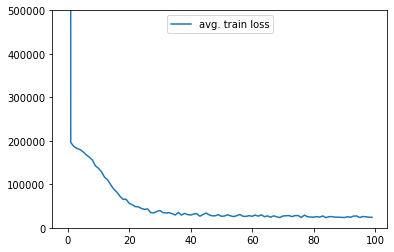

In [80]:
# 400 epochs at lr=0.00001 [done]

# ~100 epochs at lr=0.0001

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Should be per trajectory loss
plt.figure()
ax = plt.gca()
ax.set_ylim([0,500000])
plt.plot(all_losses1,label="avg. train loss")

# plt.plot(all_losses2,label="avg. validation loss")
leg = plt.legend(loc='upper center')
plt.show()

In [ ]:
# Inference on test

split = 'test'
counter = 0
currCity = 0
test_input, test_output = get_all_trajectories(split="test", normalized=False)
#We can't use a dataset or a dataloader because they don't work for the test set (something to do with the fact that the test set doesn't have outputs)

with open('predictions.txt', 'w') as f:
    print("hello",file=f, flush=True)
    for i_batch, curr_input in enumerate(test_input):
        #curr_input is a numpy array, so first we need to turn it into a tensor, then add an extra dimension around it, then make it a float tensor instead of a double tensor
        predict = mlps[currCity](torch.from_numpy(curr_input).unsqueeze(0).float())

        print("" + str(counter) + "_" + str(cities[currCity]),end='',file=f)
        for coor in predict[0]:
            print("," + str(coor[0].item()) + "," + str(coor[1].item()),end='',file=f)
        print(file=f, flush=True)
        counter = counter+1
        if counter >= test_lengths[currCity]:
            counter = 0
            currCity = currCity+1

    f.close()